## Download the data:

In [ ]:
!kaggle competitions download -c digit-recognizer

In [ ]:
!mkdir data
!unzip digit-recognizer.zip -d data

## Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats
from datetime import datetime
from scipy.stats import pearsonr
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

# Since the dataset has a large number of features, it's best to let Pandas display all the columns of the dataframe
pd.options.display.max_columns = None
# Turn off Future Warnings 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



import timeit


In [1]:
# Read the training data
import pandas as pd
train_df = pd.read_csv("data/train.csv")
# Read the test data
test_df = pd.read_csv("data/test.csv")
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [97]:
## Display a sample of training dataset

y_train = train_df['label'].astype('int32')
X_train = (train_df.drop(['label'], axis = 1)).values.astype('float32')
X_test = test_df.values.astype('float32')

batch_size, img_rows, img_cols = 64, 28, 28
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

X_train.shape, X_test.shape

((42000, 28, 28, 1), (28000, 28, 28, 1))

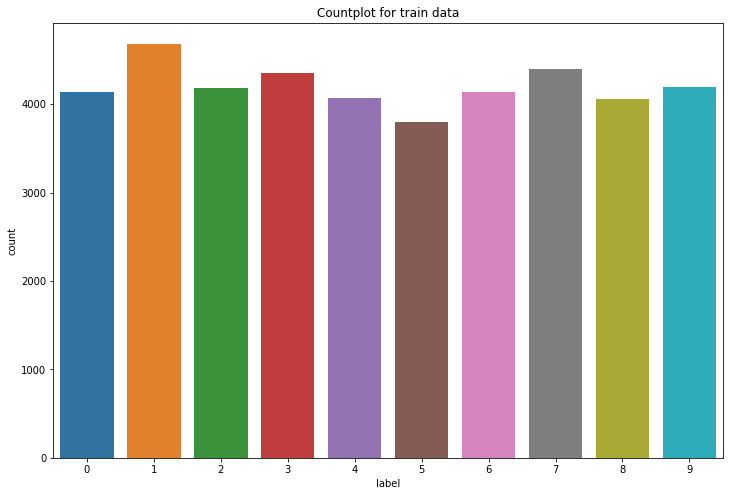

In [100]:
# ploting countplot for train data
plt.figure(figsize=(12,8))
plt.title('Countplot for train data')
sns.countplot(y_train);

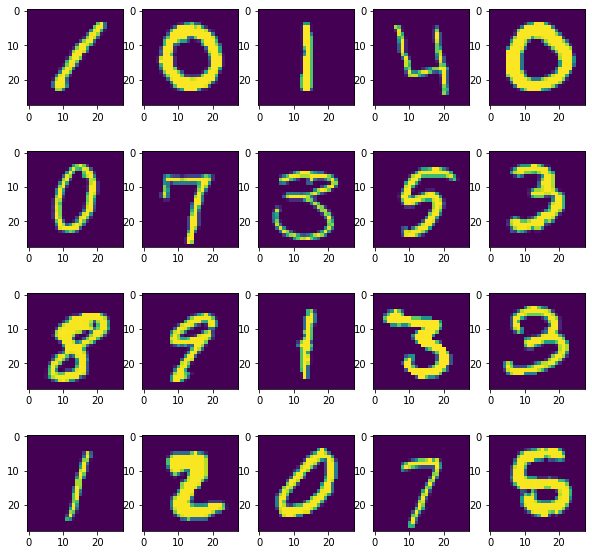

In [101]:
# images 
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(X_train[i].reshape((28, 28)))
plt.show()

## Autoencoders

In [2]:
from keras.models import Model
from keras.layers import *
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from keras.utils import to_categorical
batch_size = 256
epochs = 20
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))
num_classes = 10

Using TensorFlow backend.


### Encoder

In [3]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

### Decoder

In [4]:
def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [5]:
model_ae = Model(input_img, decoder(encoder(input_img)))
model_ae.compile(loss='mean_squared_error', optimizer = 'rmsprop')
model_ae.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        1849

In [6]:
train = train_df.copy()
test = test_df.copy()
label = train['label']
train = train.drop('label', axis=1)

In [7]:
train = np.array(train)/255
train = train.reshape(-1,28,28,1)
train.shape

(42000, 28, 28, 1)

In [8]:
test = np.array(test)/255
test = test.reshape(-1,28,28,1)
test.shape

(28000, 28, 28, 1)

In [9]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train,
                                                             train,
                                                             test_size=0.2,
                                                             random_state=11)

In [12]:
ae_train = model_ae.fit(train_X, train_ground, batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(valid_X, valid_ground))

Train on 33600 samples, validate on 8400 samples
Epoch 1/20
33600/33600 [==============================] - 22s 651us/step - loss: 0.0512 - val_loss: 0.0922
Epoch 2/20
33600/33600 [==============================] - 17s 517us/step - loss: 0.0159 - val_loss: 0.0538
Epoch 3/20
33600/33600 [==============================] - 18s 524us/step - loss: 0.0102 - val_loss: 0.0110
Epoch 4/20
33600/33600 [==============================] - 17s 516us/step - loss: 0.0079 - val_loss: 0.0082
Epoch 5/20
33600/33600 [==============================] - 17s 515us/step - loss: 0.0066 - val_loss: 0.0123
Epoch 6/20
33600/33600 [==============================] - 17s 518us/step - loss: 0.0056 - val_loss: 0.0086
Epoch 7/20
33600/33600 [==============================] - 17s 519us/step - loss: 0.0049 - val_loss: 0.0091
Epoch 8/20
33600/33600 [==============================] - 17s 514us/step - loss: 0.0042 - val_loss: 0.0086
Epoch 9/20
33600/33600 [==============================] - 17s 514us/step - loss: 0.0043 - val_l

In [13]:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(den)
    return out

In [14]:
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))
for l1,l2 in zip(full_model.layers[:19],model_ae.layers[0:19]):
    l1.set_weights(l2.get_weights())

In [15]:
model_ae.get_weights()[0][1]

array([[[-0.14838682, -0.05641411, -0.12042704, -0.03949843,
         -0.12780322, -0.02966953, -0.10011492,  0.16615427,
         -0.0005739 ,  0.04795439,  0.05239533,  0.00534661,
         -0.10277177,  0.00040003, -0.10897785,  0.05196333,
          0.1165596 ,  0.15501902, -0.09119468,  0.1888966 ,
         -0.08128654, -0.11977052,  0.06827058,  0.06843527,
          0.07959149, -0.01880322, -0.13845494, -0.05037967,
         -0.11168885,  0.09950605, -0.03191673,  0.11800557]],

       [[-0.09701659, -0.03674844, -0.03518578, -0.20385708,
         -0.0972399 ,  0.15263739,  0.08062027, -0.01081589,
         -0.12801057,  0.09658322, -0.1263514 , -0.09828495,
         -0.06774127, -0.03268444,  0.12028677, -0.13013758,
          0.14407645, -0.14688793, -0.09478776, -0.00256333,
         -0.03877006, -0.10250745, -0.01262253, -0.01066949,
         -0.13965409,  0.0407744 ,  0.07986237, -0.05876436,
         -0.13912751, -0.07094021, -0.0044866 ,  0.10850671]],

       [[-0.153452

In [16]:
full_model.get_weights()[0][1]

array([[[-0.14838682, -0.05641411, -0.12042704, -0.03949843,
         -0.12780322, -0.02966953, -0.10011492,  0.16615427,
         -0.0005739 ,  0.04795439,  0.05239533,  0.00534661,
         -0.10277177,  0.00040003, -0.10897785,  0.05196333,
          0.1165596 ,  0.15501902, -0.09119468,  0.1888966 ,
         -0.08128654, -0.11977052,  0.06827058,  0.06843527,
          0.07959149, -0.01880322, -0.13845494, -0.05037967,
         -0.11168885,  0.09950605, -0.03191673,  0.11800557]],

       [[-0.09701659, -0.03674844, -0.03518578, -0.20385708,
         -0.0972399 ,  0.15263739,  0.08062027, -0.01081589,
         -0.12801057,  0.09658322, -0.1263514 , -0.09828495,
         -0.06774127, -0.03268444,  0.12028677, -0.13013758,
          0.14407645, -0.14688793, -0.09478776, -0.00256333,
         -0.03877006, -0.10250745, -0.01262253, -0.01066949,
         -0.13965409,  0.0407744 ,  0.07986237, -0.05876436,
         -0.13912751, -0.07094021, -0.0044866 ,  0.10850671]],

       [[-0.153452

In [17]:
for layer in full_model.layers[0:19]:
    layer.trainable = False

In [18]:
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
full_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_15 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_16 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 14, 14, 64)        1849

In [19]:
train_Y_one_hot = to_categorical(label)
test_Y_one_hot = to_categorical(label)
train_X,valid_X,train_label,valid_label = train_test_split(train,train_Y_one_hot,test_size=0.3,random_state=11)

In [20]:
classify_train = full_model.fit(train_X, train_label, batch_size=256,epochs=20,verbose=2,validation_data=(valid_X, valid_label))

Train on 29400 samples, validate on 12600 samples
Epoch 1/20
 - 5s - loss: 0.3635 - accuracy: 0.9135 - val_loss: 0.2417 - val_accuracy: 0.9555
Epoch 2/20
 - 4s - loss: 0.1137 - accuracy: 0.9757 - val_loss: 0.6254 - val_accuracy: 0.9614
Epoch 3/20
 - 4s - loss: 0.0698 - accuracy: 0.9882 - val_loss: 0.2916 - val_accuracy: 0.9646
Epoch 4/20
 - 4s - loss: 0.0521 - accuracy: 0.9935 - val_loss: 0.2095 - val_accuracy: 0.9671
Epoch 5/20
 - 4s - loss: 0.0350 - accuracy: 0.9957 - val_loss: 0.2403 - val_accuracy: 0.9675
Epoch 6/20
 - 4s - loss: 0.0218 - accuracy: 0.9973 - val_loss: 0.2028 - val_accuracy: 0.9676
Epoch 7/20
 - 4s - loss: 0.0134 - accuracy: 0.9980 - val_loss: 0.1653 - val_accuracy: 0.9694
Epoch 8/20
 - 4s - loss: 0.0150 - accuracy: 0.9972 - val_loss: 0.4208 - val_accuracy: 0.9667
Epoch 9/20
 - 4s - loss: 0.0237 - accuracy: 0.9971 - val_loss: 0.3532 - val_accuracy: 0.9666
Epoch 10/20
 - 4s - loss: 0.0483 - accuracy: 0.9944 - val_loss: 0.4642 - val_accuracy: 0.9652
Epoch 11/20
 - 4s -

In [21]:
full_model.save_weights('classification_complete.h5')

In [22]:
predicted_classes = full_model.predict(test)
preds = np.argmax(predicted_classes,axis=1)

In [23]:
results = pd.Series(preds,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

print(submission)

       ImageId  Label
0            1      2
1            2      0
2            3      9
3            4      9
4            5      3
...        ...    ...
27995    27996      9
27996    27997      7
27997    27998      3
27998    27999      9
27999    28000      2

[28000 rows x 2 columns]


In [24]:
submission.to_csv("submission_ae.csv",index=False)